# Homework 1: Extreme Scattering Events

## Q1:

Write a library (i.e., in a separate file that you can call) for the three root-finding algorithms we
discussed in class: Bisection, Newton, Secant. These functions should each take _functions_ rather than data
points. Make sure that each takes an optional argument the threshold and that it also takes a variable that
allows the user to print out or return the number of iterations it took to hit that threshold.

**This is found in rootfinding.py.**

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
import astropy.units as u

import rootfinding as rf
from interpolation import linear_interpolator

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

-----

## Q2: 
For the pseudo-isothermal sphere, using your root-finding algorithms, numerically calculate the full width at half maximum, i.e., what is the width (in terms of $r_c$) when $N_e(x) = N_0/2$, half the amplitude. Drawing pictures for yourself might be useful! Do so with each of your root-finding algorithms and show how many iterations each takes as a function of your threshold. Please plot the results.

Numeric functions to solve are listed below, and include $N_e(x)$, $\frac{d}{dx} N_e(x)$, and the FWHM function defined as $N_e(x)-0.5N_0$

In [2]:
def N_e(x, N_0=1, r_c=1):
    """ Column density for pseudo-isothermal sphere """
    x = float(x)
    return N_0/np.sqrt(1+(x/r_c)**2)

def N_e_prime(x, N_0=1, r_c=1):
    """ Gradient of column density for pseudo-isothermal sphere """
    x = float(x)
    return -N_0*x/(r_c**2 * (1+(x/r_c)**2)**1.5)
    
def fwhm_func(x, N_0=1):
    """ Root-finding function to solve """
    return N_e(x)-0.5*N_0

Print the results of the root finding. Note that we multiply by 2 to get the FWHM since we are only finding the positive side of the expression.

In [3]:
print("Bisect method FWHM:", 2*rf.bisect(fwhm_func, 0, 5))
print("Netwon method FWHM:", 2*rf.newton(fwhm_func, N_e_prime, 2.5)) #gradient is the same as N_e_prime
print("Secant method FWHM:", 2*rf.secant(fwhm_func, 0, 5))

Bisect method FWHM: 3.464101552963257
Netwon method FWHM: 3.464101602865013
Secant method FWHM: 3.464101959455062


If you analytically consider solving the function $(1 + x^2)^{-0.5} = 1/2$, you find that $x = \sqrt{3}$. Multiplying by the factor of 2, we get the answers above.

Calculate how many iterations the procedures take as a function of the threshold

In [4]:
thresholds = np.logspace(-1, -12, 24)
numiters = np.zeros((3, len(thresholds)))
for i, threshold in enumerate(thresholds):
    _, numiters[0, i] = rf.bisect(fwhm_func, 0, 5, threshold=threshold, full_output=True)
    _, numiters[1, i] = rf.newton(fwhm_func, N_e_prime, 2.5, threshold=threshold, full_output=True)
    _, numiters[2, i] = rf.secant(fwhm_func, 0, 5, threshold=threshold, full_output=True)

Plot the log-threshold versus the number of iterations, in order to show the linear vs superlinear convergence as discussed in class

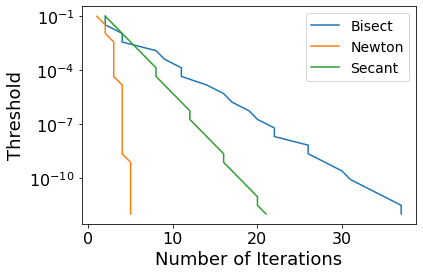

In [5]:
plot(numiters[0, :], thresholds, label="Bisect")
plot(numiters[1, :], thresholds, label="Newton")
plot(numiters[2, :], thresholds, label="Secant")
yscale('log')
xlabel('Number of Iterations')
ylabel('Threshold')
legend()

-----

## Q3:
You can probably see from the Gaussian Lens equations that if you have a light ray hitting $x$, and
you know the other parameters of the lens ($a$, $N_0$, $D$, etc.), then you know what $x'$ is. But that's boring.
Let’s say you are an observer in a "circular orbit" along the $x'$ axis with radius 1 AU and a period of 1
year but centered at $x'$ = 1 AU. Then, you know where your position $x'$ is but not where the light rays from the source are intersecting the lens plane at $x$ - as expected, analytically solving for x is not really an option.

Using one of your root-finding algorithms, make a raytracing plot as on the first page. Assume $D$ = 1 kpc, $a$ = 1 AU, $\lambda$ = 21 cm, and $N_0$ = 0.01 pc cm$^{-3}$ (these are observer units, probably best to convert to something like cm$^{-2}$).

In [6]:
r_e = 2.81794e-13*u.cm

def lens_equation_Gaussian(xprime, D=1.0*u.kpc, a=1*u.AU, lam=21.0*u.cm, N_0=0.01*u.pc/u.cm**3):
    """ Lens equation specifically written for the Gaussian case, not generic """
    const = ((lam**2*r_e*N_0*D)/(np.pi*a**2)).to(u.dimensionless_unscaled)
    return lambda x: (xprime - x*(1+ const* np.exp(-(x/a).to(u.dimensionless_unscaled)**2))).value

In [7]:
xprimes = np.linspace(0, 2, 20)
xs = np.zeros(len(xprimes))
for i, xprime in enumerate(xprimes):
    func = lens_equation_Gaussian(xprime*u.AU)
    xs[i] = rf.secant(func, 0*u.AU, 2*u.AU).value

Below is the plot of the refraction angles. For clarity, I show rays coming straight from a source at large $d$, though of course the axes are not equally scaled.

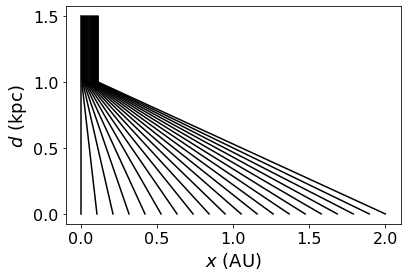

In [8]:
for i, xprime in enumerate(xprimes):
    plot([xprimes[i], xs[i], xs[i]], [0, 1, 1.5],'k')
xlabel(r'$x~(\mathrm{AU})$')
ylabel(r'$d~(\mathrm{kpc})$')
show()

I'm drawing plane waves coming from the source but one could also raytrace back to some point source as well.

-----

## Q4:
Repeat but for the pseudo-isothermal sphere with the same parameters but $r_c$ = 1 AU.

We are given the form
$$N_e(x) = N_0\left[1+\left(\frac{x}{r_c}\right)^2\right]^{-1/2}$$
for the pseudo-isothermal sphere, with the gradient
$$\frac{d}{dx}N_e(x) = -\frac{N_0 x}{r_c^2 \left[1+\left(x/r_c\right)^2\right]^{3/2}}$$.

Therefore, we can solve for the refraction angle as
$$\theta_r(x) = \frac{\lambda^2 r_e}{2\pi} \frac{d}{dx}N_e(x) = -\frac{\lambda^2 r_e}{2\pi} \frac{N_0 x}{r_c^2 \left[1+\left(x/r_c\right)^2\right]^{3/2}}$$
The lens equation is $x' = x-\theta_r(x)D$ and so we can solve as appopriate.

Below is a more generic version of the lens equation, rather than tailoring it to one specific functional form. I will write $a$ instead of $r_c$ in this case.

In [9]:
def theta_r_pseudo(x, a=1*u.AU, lam=21.0*u.cm, N_0=0.01*u.pc/u.cm**3):
    """ Refraction angle in the pseudo-isothermal case """
    return (-lam**2*r_e/(2*np.pi) * (N_0*x)/(a**2 * (1+(x/a)**2))).to(u.dimensionless_unscaled)


def lens_equation(xprime, theta_r, D=1.0*u.kpc):
    """ Generic lens equation """
    return lambda x: (xprime - x + theta_r(x)*D.to(u.AU)).value

In [10]:
xprimes = np.linspace(0, 2, 20)
xs = np.zeros(len(xprimes))
for i, xprime in enumerate(xprimes):
    func = lens_equation(xprime*u.AU, theta_r_pseudo)
    xs[i] = rf.secant(func, 0*u.AU, 2*u.AU).value

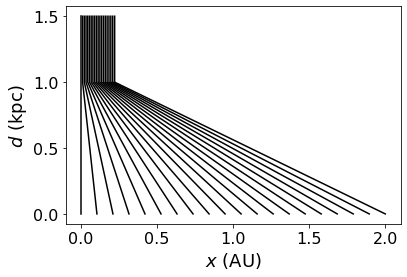

In [11]:
for i, xprime in enumerate(xprimes):
    plot([xprimes[i], xs[i], xs[i]], [0, 1, 1.5],'k')
xlabel(r'$x~(\mathrm{AU})$')
ylabel(r'$d~(\mathrm{kpc})$')
show()

We can see that in this case, the raypaths are a bit broader. This makes sense because if we plot the two $N_e(x)$ profiles for the Gaussian and psuedo-isothermal lenses, we see that the pseudo-isothermal lens is broader if the characteristic scale $r_c$ is the same as $a$. Therefore, the derivative $dN_e/dx$ is smaller and the refracitve angle $\theta_r$ is smaller.

Text(0, 0.5, '$N_e(x)/N_0$')

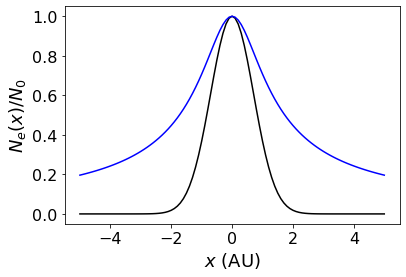

In [12]:
xprimes = np.linspace(-5, 5, 101)
plot(xprimes, np.exp(-xprimes**2), 'k')
plot(xprimes, (1 + xprimes**2)**-0.5, 'b')
xlabel(r'$x$ (AU)')
ylabel(r'$N_e(x)/N_0$')

-----

## Q5:
Write a library for piecewise linear interpolation, given a set of $x$ and $y$ data points. This should
return a function $f$ that one can use to calculate a new point $f(x_{\rm new}) \to y_{\rm new}$.

**This is found in interpolator.py.**

-----

## Q6:
In the file lens_density.txt are a series of values of $x$ and $N_e(x)$ for some shape. Use your interpolator to plot the values of $N_e(x)$ halfway in between all of the given $x$ values, i.e., when $x = 0.5, 1.5, \cdots$.

In [13]:
x, N_e = np.loadtxt("lens_density.txt", unpack=True, delimiter=',')

Text(0, 0.5, '$N_e$')

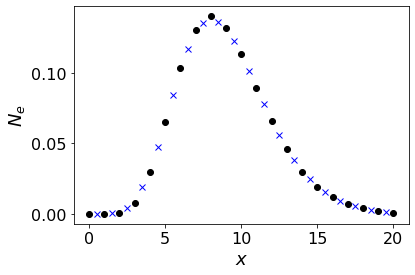

In [14]:
x_new = np.arange(0.5, 20.5, 1)
func = linear_interpolator(x, N_e)

# My function does not allow one to pass an array as an argument, 
# only a single value, so we have to loop over, or in this case
# use map()
N_e_new = np.array(list(map(func, x_new)))
plot(x, N_e, 'ko')
plot(x_new, N_e_new, 'bx')
xlabel(r'$x$')
ylabel(r'$N_e$')